In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import os
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering

from IPython.display import clear_output

2023-10-28 16:51:47.244204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 16:51:47.244346: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 16:51:47.244897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 16:51:47.320792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BATCH_SIZE = 1000

In [3]:
def load_and_preprocess_images(input_image_path, label):
    input_image = tf.io.read_file(input_image_path)
    input_image = tf.image.decode_image(input_image, channels=1, expand_animations = False) 
    input_image = tf.image.resize(input_image, (28, 28))  
    return input_image, label
    # parent_folder = path.split("/")[-2]
    # print(parent_folder)
    # return input_image, parent_folder

def create_dataset_generator( folder_name = "train", BATCH_SIZE = 1000 ):
    input_image_paths = []
    labels = []

    input_image_dir = os.path.join( os.getcwd(), folder_name )

    input_image_folders = [ os.path.join( input_image_dir , folder_name ) for folder_name in os.listdir(input_image_dir) ]

    for input_image_folder in input_image_folders :
    #     for image_path in os.listdir(input_image_folder):
    #         input_image_paths.append( os.path.join(input_image_folder, image_path) )
        for filename in os.listdir(input_image_folder):
            if filename[-3:] == "jpg":
                input_image_paths.append(os.path.join( input_image_folder , filename) )
                labels.append(os.path.basename(input_image_folder) )

    image_dataset = tf.data.Dataset.from_tensor_slices(input_image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    data = tf.data.Dataset.zip(image_dataset, label_dataset)


    data = data.map(load_and_preprocess_images)
    data = data.shuffle(buffer_size=60000)  
    data = data.batch(BATCH_SIZE)
    return data

dataset = create_dataset_generator()


2023-10-28 16:51:53.583026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-28 16:51:53.625553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-28 16:51:53.625621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-28 16:51:53.638347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-28 16:51:53.638414: I tensorflow/compile

In [4]:
def label_to_string( label ):
    return tf.strings.reduce_join(label, separator = "" ).numpy().decode() 

In [5]:
kmeans = MiniBatchKMeans( n_clusters = 10, init = "k-means++", n_init = "auto", random_state=0, max_iter= 5000, batch_size= 500 )

In [6]:

def plot_points(embeddings,labels , clear_screen = True, mention_labels = False):
    # colors = ["red", "green", "blue", "violet", "black", "brown", "cyan", "pink" , "lightgreen", "navy", "Magenta"]
    group_to_num = {group: i for i, group in enumerate(np.unique(labels))}
    cmap = plt.get_cmap('tab10')
    colors = cmap([group_to_num[group] for group in labels])
    num = [group_to_num[group] for group in labels]
    if (clear_screen):
        clear_output(wait = True)
    pca = PCA(n_components = 2)
    embeddings_2d = pca.fit_transform(embeddings)
    # Create a scatter plot
    plt.figure(figsize=(10, 10))
    fig,ax = plt.subplots()
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1] , c = num , cmap= "tab10")
    legend1 = ax.legend(*scatter.legend_elements(num=10),
                    loc="upper left", title="Category")
    ax.add_artist(legend1)
    if mention_labels:
        for i, label in enumerate(labels):
            try:
                ax.annotate( label_to_string(label)[:2], (embeddings_2d[i, 0], embeddings_2d[i, 1]) )
            except:
                ax.annotate( label, (embeddings_2d[i, 0], embeddings_2d[i, 1]) )
    print(group_to_num)

    plt.title("Image Embeddings Visualization (2D)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{b'Angle boot': 0, b'Bag': 1, b'Coat': 2, b'Dress': 3, b'Pullover': 4, b'Sandal': 5, b'Shirt': 6, b'Sneaker': 7, b'T-shirt': 8, b'Trouser': 9}


<Figure size 1000x1000 with 0 Axes>

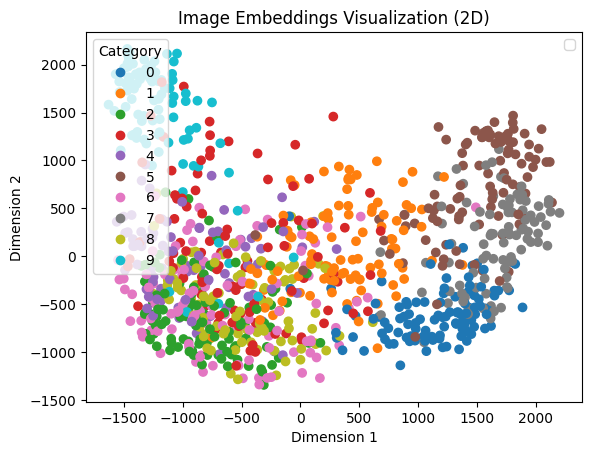

In [7]:

base_options = python.BaseOptions(model_asset_path='./MediapipeModel/mobilenet_v3_small_075_224_embedder.tflite')
l2_normalize = True 
quantize = True 
options = vision.ImageEmbedderOptions(base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)

with vision.ImageEmbedder.create_from_options(options) as embedder :
    for i in range( 0, len(dataset) ):

        embeddings = [] 

        for batch in dataset.take(1):
            images, labels = batch
            for img in images.numpy().astype("uint8"):
                embedding_result = embedder.embed( mp.Image( mp.ImageFormat.GRAY8 , data = img ) )
                embeddings.append( embedding_result.embeddings[0].embedding )

        plot_points(embeddings,labels.numpy())
        kmeans.partial_fit(np.array(embeddings), np.array(labels) )

In [8]:
labels

<tf.Tensor: shape=(1000,), dtype=string, numpy=
array([b'Shirt', b'Pullover', b'Dress', b'Sneaker', b'T-shirt',
       b'T-shirt', b'Trouser', b'Coat', b'T-shirt', b'Shirt',
       b'Angle boot', b'Pullover', b'Sandal', b'Shirt', b'Sneaker',
       b'Dress', b'Sneaker', b'Shirt', b'Trouser', b'T-shirt', b'Sneaker',
       b'Shirt', b'T-shirt', b'Angle boot', b'Bag', b'Dress', b'Coat',
       b'Shirt', b'Shirt', b'Pullover', b'Coat', b'Sneaker', b'Coat',
       b'Shirt', b'Sneaker', b'T-shirt', b'Sneaker', b'Shirt',
       b'Angle boot', b'Trouser', b'Trouser', b'Coat', b'Pullover',
       b'Shirt', b'Dress', b'Sneaker', b'Sneaker', b'Angle boot',
       b'Sneaker', b'Shirt', b'T-shirt', b'Dress', b'Trouser',
       b'Pullover', b'Trouser', b'Pullover', b'Bag', b'Shirt',
       b'Pullover', b'Coat', b'Shirt', b'Coat', b'Trouser', b'Sandal',
       b'Sneaker', b'Coat', b'Sneaker', b'Dress', b'Angle boot', b'Shirt',
       b'Sneaker', b'Coat', b'Pullover', b'Sneaker', b'Sneaker',
       b

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{b'Angle boot': 0, b'Bag': 1, b'Coat': 2, b'Dress': 3, b'Pullover': 4, b'Sandal': 5, b'Shirt': 6, b'Sneaker': 7, b'T-shirt': 8, b'Trouser': 9}


<Figure size 1000x1000 with 0 Axes>

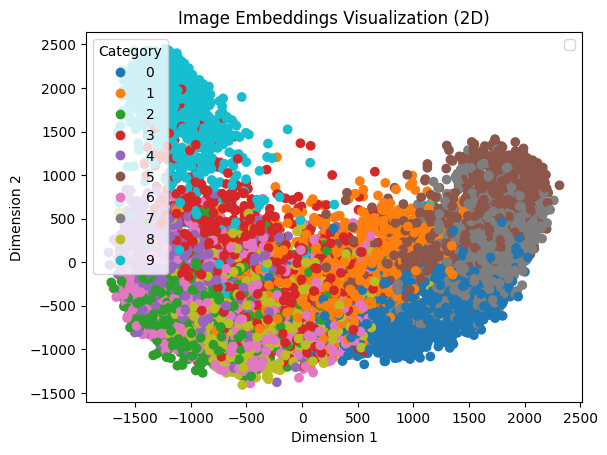

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


<Figure size 1000x1000 with 0 Axes>

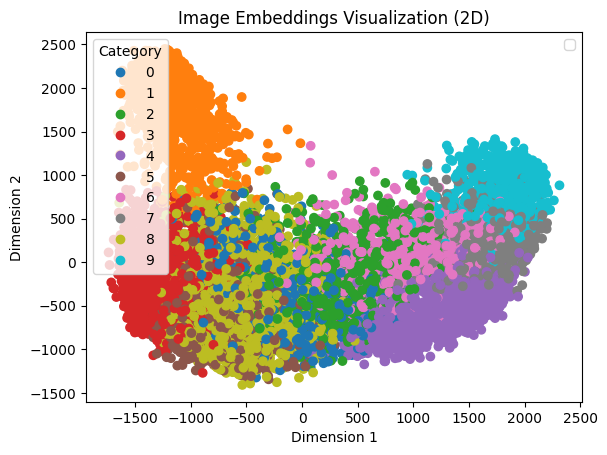

In [14]:
test_dataset = create_dataset_generator("test", 10000)
with vision.ImageEmbedder.create_from_options(options) as embedder :
    for batch in test_dataset.take(1):
        embeddings = []
        images, labels = batch
        for img in images.numpy().astype("uint8"):
            embedding_result = embedder.embed( mp.Image( mp.ImageFormat.GRAY8 , data = img ) )
            embeddings.append( embedding_result.embeddings[0].embedding )

        
    plot_points(embeddings,labels.numpy(),False)
    
    plot_points( embeddings , kmeans.predict( np.array(embeddings) ),False )